<a href="https://colab.research.google.com/github/jenfad/machinelearning_code_along/blob/main/Seoul_Bikes_FCC_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

#Dataset
Seoul Bike Sharing Demand. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R. \
Donated on 2/29/2020 \
Website to obtain: http://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand \


#Setup

In [2]:
#importing the dataset file by selecting it from a folder on my drive
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving SeoulBikeData.csv to SeoulBikeData.csv
User uploaded file "SeoulBikeData.csv" with length 598980 bytes


In [3]:
#cleaned up some of the headers in the csv by getting rid of the degree symbol so that it could be read into a dataframe without throwing a decoding error
#dropping some of the columns that we don't need
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [4]:
#creating an array that will be used to rename the columns with no spaces
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]

In [ ]:
df.head

<bound method NDFrame.head of       Rented Bike Count  Hour  Temperature(C)  Humidity(%)  Wind speed (m/s)  \
0                   254     0            -5.2           37               2.2   
1                   204     1            -5.5           38               0.8   
2                   173     2            -6.0           39               1.0   
3                   107     3            -6.2           40               0.9   
4                    78     4            -6.0           36               2.3   
...                 ...   ...             ...          ...               ...   
8755               1003    19             4.2           34               2.6   
8756                764    20             3.4           37               2.3   
8757                694    21             2.6           39               0.3   
8758                712    22             2.1           41               1.0   
8759                584    23             1.9           43               1.3   

      Vis

In [5]:
#Renaming the columns with names that have no spaces
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df.columns = dataset_cols

#changing column values to 1 or 0 where possible, since it's easier to build a model from that
df["functional"] = (df["functional"] == "Yes").astype(int)

#Filtering just for records where the hour is 12 so we can model for that hour and then dropping the hour column
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [ ]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


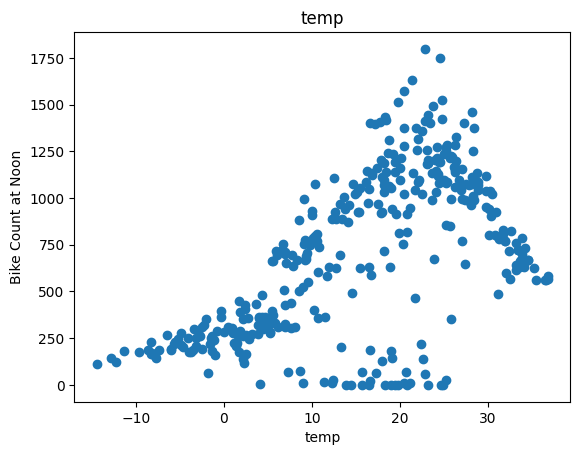

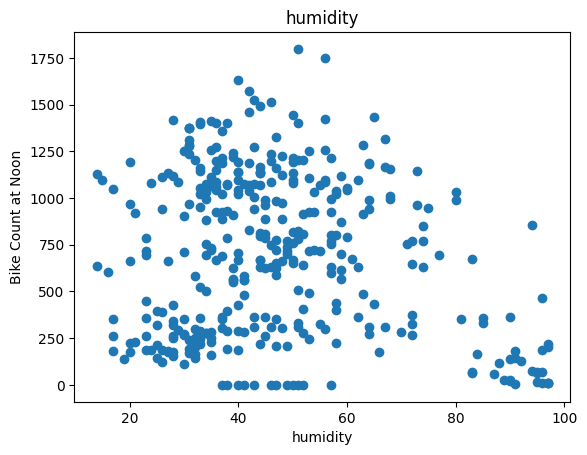

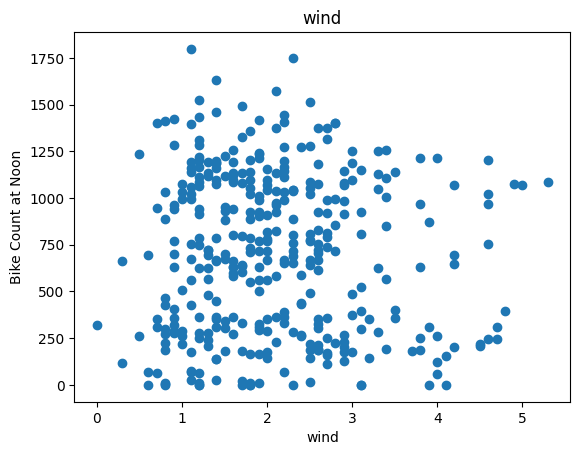

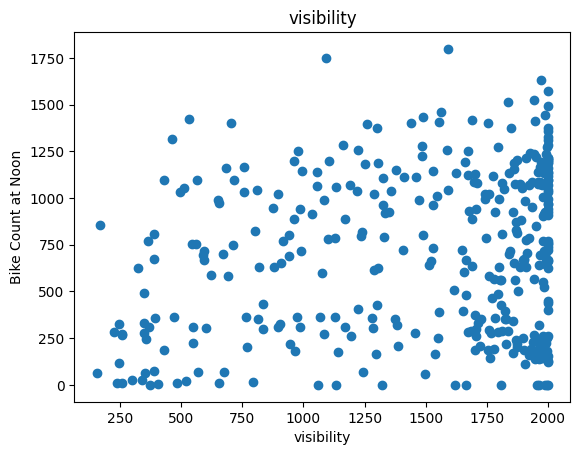

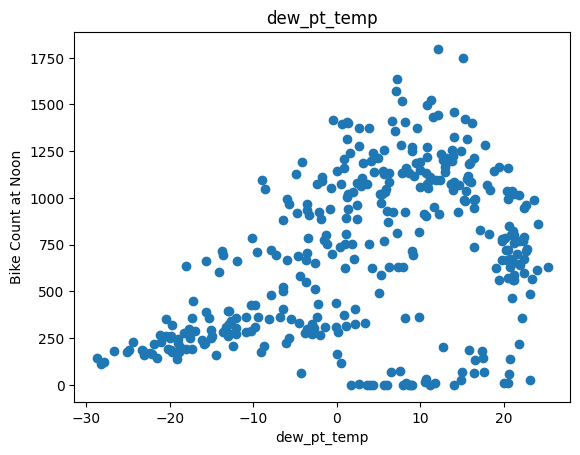

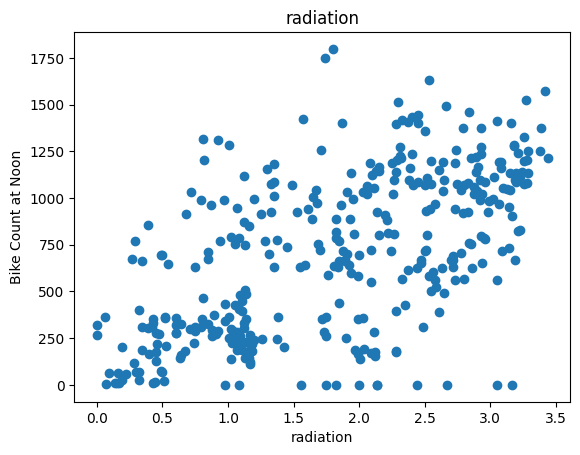

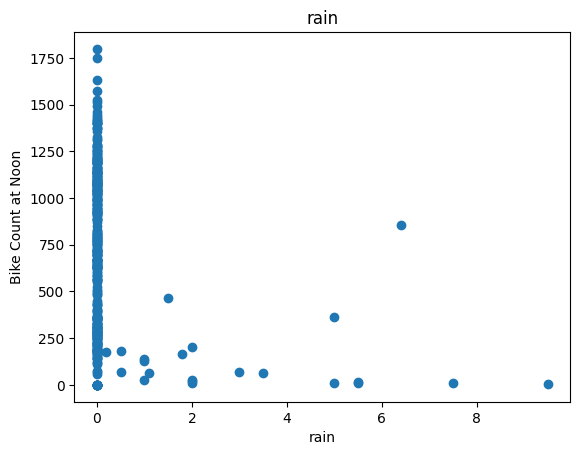

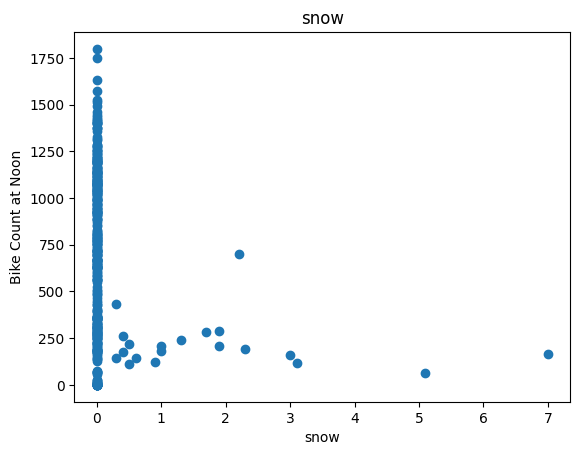

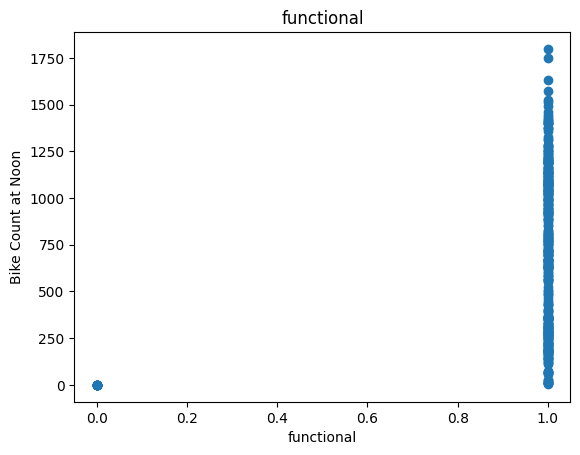

In [6]:
#create a plot for each column starting from "temp" to the end of the dataframe columns (i.e. exclude "bike_count")
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("Bike Count at Noon")
  plt.xlabel(label)
  plt.show()

In [7]:
#based on the above plots, seems like some feaures are not related to the bike count so we're dropping them
df = df.drop(["wind", "visibility", "functional"], axis=1)

#Train, Validation and Test Datasets

In [8]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [9]:
#function to get x(some or all the labels) and y values from a dataframe
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
    if len(x_labels) == 1:
      #if only one x_label is specified, reshape the array of values to be viewed as two dimensional with one column so that it can be horizontally stacked later in this formula
      X = dataframe[x_labels[0]].values.reshape(-1, 1)
    else:
      X = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((X, y))

  #getting the dataframe with both x and y, as well as x and y values separately
  return data, X, y

#Linear Regression

In [10]:
#for linear regression, we will just select one of the x labels (temp)
x_and_y, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
x_and_y, x_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
x_and_y, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [11]:
#training a linear regression model
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [12]:
temp_reg.score(x_test_temp, y_test_temp)

0.3049237915205588

The R<sup>2</sup> value is greater than 0 (meaning there's some correlation) but not too high



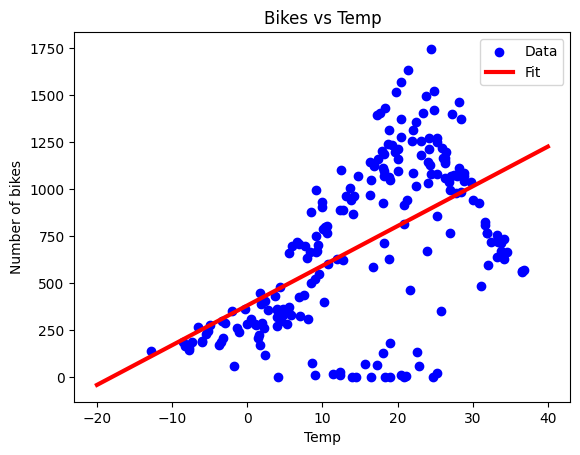

In [14]:
#comparing the training data points to the predicted line
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
#creating values that run from -20 to 40 evenly so can use it to predict and draw the resulting line
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

#Multiple Linear Regression


In [15]:
#for multiple linear regression, we don't need to select just one label, bike_count should be excluded from x since it was labelled as the Y_label (see formula def above)
x_and_y, x_train_all, y_train_all = get_xy(train, "bike_count")
x_and_y, x_val_all, y_val_all = get_xy(val, "bike_count")
x_and_y, x_test_all, y_test_all = get_xy(test, "bike_count")

In [16]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [17]:
all_reg.score(x_test_all, y_test_all)

0.43451137763515835

R<sup>2</sup> has improved compared to just using linear regression with temp as the independent variable

#Regression with Neural Net

In [18]:
#normalize data since linear regression model; scale inputs into a distribution centered around 0 with standard deviation 1
#see this article about normalization vs. standardization https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
#axis = None means mean and variance accross all elements of the input (not by each feature in a specified axis)
#just doing it on one temperature so input shape will be of (1,)
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
#reshape to single vector
temp_normalizer.adapt(x_train_temp.reshape(-1))

In [19]:
#sequential model with one node and no activation means that it's linear and output is linear
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [20]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [21]:
history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(x_val_temp, y_val_temp)
)

In [22]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

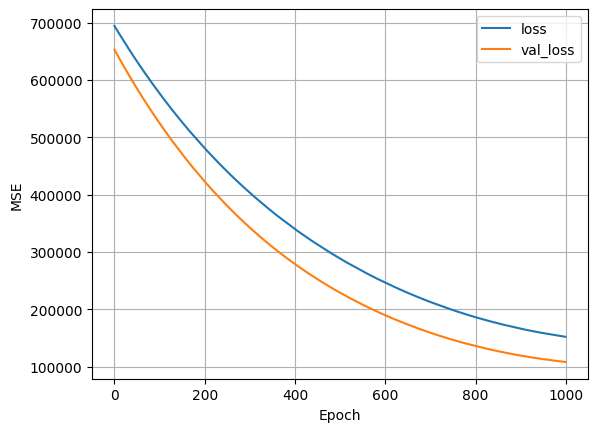

In [23]:
plot_loss(history)

4/4 [==============================] - 0s 2ms/step


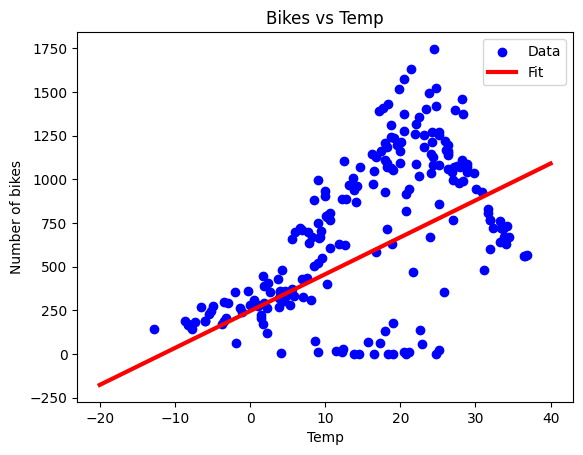

In [24]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

Can see different line than one saw above when running linear regression and it's because for this section, we are using backpropogation to train the model

#Neural Net
(Not linear)

In [25]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

#running again using temperature as the feature but with 32 nodes, ativation and multiple layers
#using reLU activation since the bike count can't be negative

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [27]:
#batch_size (number of samples taken of data) defaults to 32
history = nn_model.fit(
    x_train_temp, y_train_temp,
    validation_data=(x_val_temp, y_val_temp),
    verbose=0, epochs=100
)

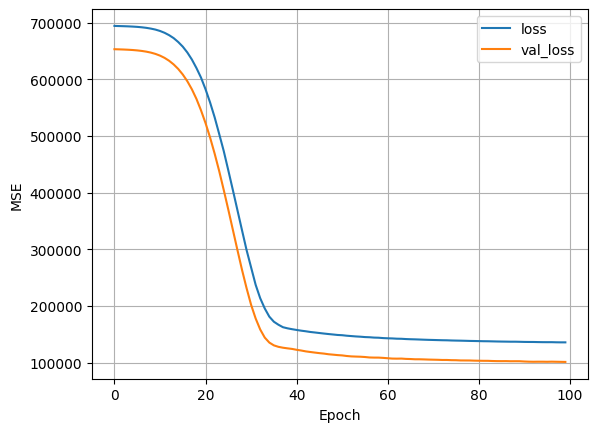

In [28]:
plot_loss(history)

4/4 [==============================] - 0s 2ms/step


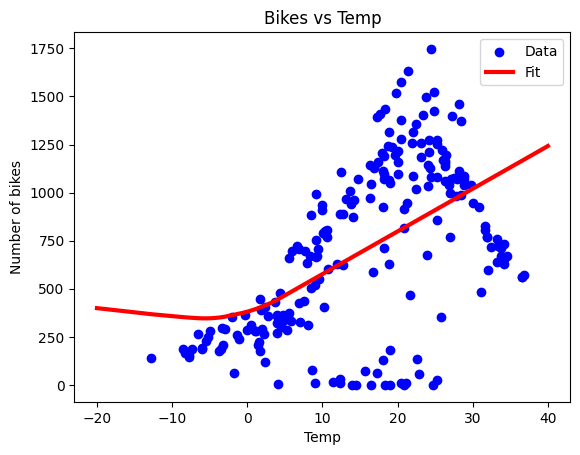

In [29]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

Can keep adjusting parameters of model to get a better fit (e.g. adding additional layers, etc.), but will run using multiple feaures next

In [30]:
#running using all features not just temperature
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(x_train_all)

In [31]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [32]:
history = nn_model.fit(
    x_train_all, y_train_all,
    validation_data=(x_val_all, y_val_all),
    verbose=0, epochs=100
)

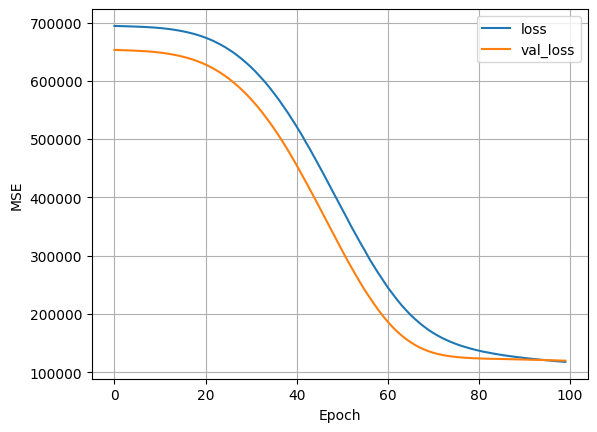

In [33]:
plot_loss(history)

In [34]:
# calculating the MSE for linear regression and neural net model (since can't use R^2 for n)
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = nn_model.predict(x_test_all)

3/3 [==============================] - 0s 3ms/step


In [35]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()

In [36]:
MSE(y_pred_lr, y_test_all)

97666.70256824647

In [37]:
MSE(y_pred_nn, y_test_all)

124392.82106793136

Between the two models we ran, it appears that the linear regression one performed better than the neural netwark

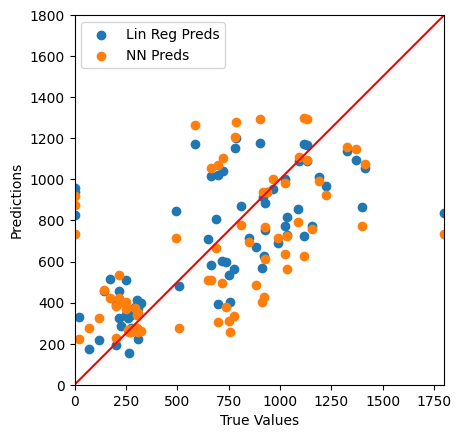

In [38]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg Preds")
plt.scatter(y_test_all, y_pred_nn, label="NN Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")